# Labo 4 : ACP sur des images
Auteurs : Julien Mühlemann, Cristhian Ronquillo  
Groupe : 5

In [48]:
%matplotlib inline


The eigenfaces example: chaining PCA and SVMs
=============================================

The goal of this example is to show how an unsupervised method and a
supervised one can be chained for better prediction. It starts with a
didactic but lengthy way of doing things, and finishes with the
idiomatic approach to pipelining in scikit-learn.

Here we'll take a look at a simple facial recognition example. Ideally,
we would use a dataset consisting of a subset of the `Labeled Faces in
the Wild <http://vis-www.cs.umass.edu/lfw/>`__ data that is available
with :func:`sklearn.datasets.fetch_lfw_people`. However, this is a
relatively large download (~200MB) so we will do the tutorial on a
simpler, less rich dataset. Feel free to explore the LFW dataset.



In [49]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

(400, 4096)

In [50]:
# Examiner la structure des données
data = faces

print("Structure des données:")
print(f"Clés disponibles dans le dataset: {data.keys()}")
print(f"Description du dataset: {data['DESCR']}")

# Informations sur le nombre de personnes et d'images
n_samples, h, w = data.images.shape
n_features = data.data.shape[1]
n_classes = len(set(data.target))

print("\nInformations détaillées:")
print(f"Nombre total d'images: {n_samples}")
print(f"Nombre de personnes (classes): {n_classes}")
print(f"Nombre d'images par personne: {n_samples // n_classes}")
print(f"Taille des images: {h}x{w} pixels")
print(f"Nombre de caractéristiques par image (après aplatissement): {n_features}")

Structure des données:
Clés disponibles dans le dataset: dict_keys(['data', 'images', 'target', 'DESCR'])
Description du dataset: .. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (wit

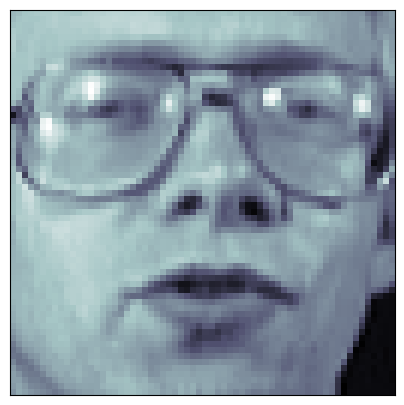

In [51]:
# Affichage d'une image tirée au sort
import numpy as np
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))

rand = np.random.randint(0, 400)

ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(faces.images[rand], cmap=plt.cm.bone)

Let's visualize these faces to see what we're working with



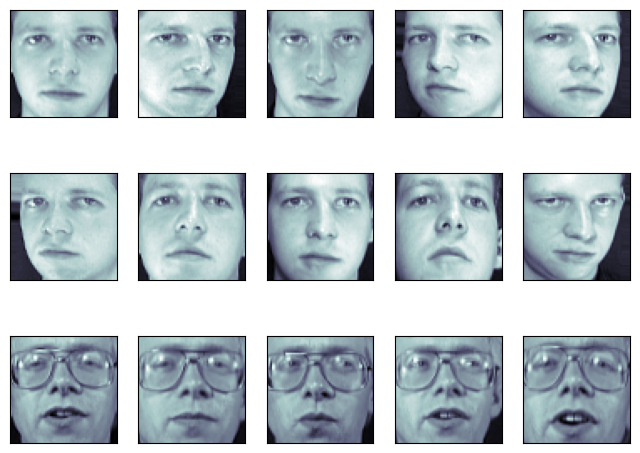

In [52]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

.. tip::

   Note is that these faces have already been localized and scaled to a
   common size. This is an important preprocessing piece for facial
   recognition, and is a process that can require a large collection of
   training data. This can be done in scikit-learn, but the challenge is
   gathering a sufficient amount of training data for the algorithm to work.
   Fortunately, this piece is common enough that it has been done. One good
   resource is
   `OpenCV <https://docs.opencv.org/2.4/modules/contrib/doc/facerec/facerec_tutorial.html>`__,
   the *Open Computer Vision Library*.

We'll perform a Support Vector classification of the images. We'll do a
typical train-test split on the images:



In [53]:
# Faire un split hold-out avec 80% d'entraînement avec stratas
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=0,
                                                    test_size=0.20, stratify=faces.target)

print(X_train.shape, X_test.shape)

(320, 4096) (80, 4096)


Pour le train, on a 320 images de 64x64 pixels, soit 4096 pixels par image. Et pour le test, on a 80 images de 64x64 pixels, soit 4096 pixels par image.

In [54]:
# Nous vérifions que les classes des dataset d'entraînement et de test sont équilibrées
unique_values, counts = np.unique(y_train, return_counts=True)
unique_values, counts



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int64))

Nous voyons que nous obtenons bien la meme qté de tuples pour chaque classe i.e. 8/10  
Dimension des jeux 320 tuples pour l'entraînement et 80 pour le test

In [55]:

def pl(a, b, txt, data):
    plt.plot(range(a, b), data, marker='o') 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(txt)
    plt.grid(True)
    plt.show()

>Tentez une expérience de classification avec chacun des classifieurs suivants : KNN, régression logistique, SVM. Quels scores de « accuracy » obtenez-vous sur le jeu de test ?

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def knn_clf(X_train, y_train, X_test, y_test):
    hist = []
    best_accu=0
    nk=0
    for k in range(1, 8):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accu = metrics.accuracy_score(y_test, y_pred)
        hist.append(accu)
        if accu > best_accu:
            best_accu = accu
            nk=k
    #pl(1, 55, "accu", hist)
    #print(f"Accu: {best_accu:.2f} best K: {nk}")
    return best_accu


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def log_reg_clf(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression(random_state=42, solver='liblinear') # changer le solveur pour éviter le warning "pas convergé"
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    accu = metrics.accuracy_score(y_test, y_pred)
    #print(f"Accu: {accu:.2f}")
    return accu


In [58]:
from sklearn import svm
from sklearn import metrics

def svc_clf(X_train, y_train, X_test, y_test):
    clf = svm.SVC(C=5., kernel='linear', gamma=0.001)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu =metrics.accuracy_score(y_test, y_pred)
    
    #print(f"Accu: {accu:.2f}")
    return accu


In [59]:
acc_1 = svc_clf(X_train, y_train, X_test, y_test)
acc_2 =knn_clf(X_train, y_train, X_test, y_test)
acc_3 = log_reg_clf(X_train, y_train, X_test, y_test)
print(f"accu svc:{acc_1}")
print(f"accu knn:{acc_2}")
print(f"accu log reg:{acc_3}")

accu svc:0.95
accu knn:0.95
accu log reg:0.9375


On voit que le meilleur score est obtenu avec le SVM et KNN avec un score de 0.95 suivis de la régression logistique avec un score de 0.9375. Ces résultats sont assez bons pour tous les classifieurs mais le SVM et KNN sont les meilleurs.

###  4. Veuillez appliquer la méthode ACP avec 150 composantes principales : construisez d’abord les composantes (appelées « eigenfaces »), puis appliquez la transformation aux données d’entraînement, puis de test. Devez-vous centrer les données avant d’appliquer l’ACP ?

Preprocessing: Principal Component Analysis
-------------------------------------------

1850 dimensions is a lot for SVM. We can use PCA to reduce these 1850
features to a manageable size, while maintaining most of the information
in the dataset.



In [60]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(n_components=150, whiten=True)

One interesting part of PCA is that it computes the "mean" face, which
can be interesting to examine:



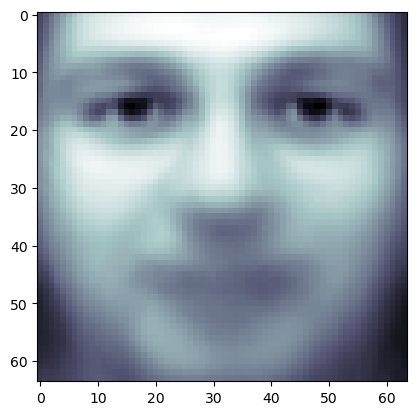

In [61]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

The principal components measure deviations about this mean along
orthogonal axes.



In [62]:
print(pca.components_.shape)

(150, 4096)


It is also interesting to visualize these principal components:



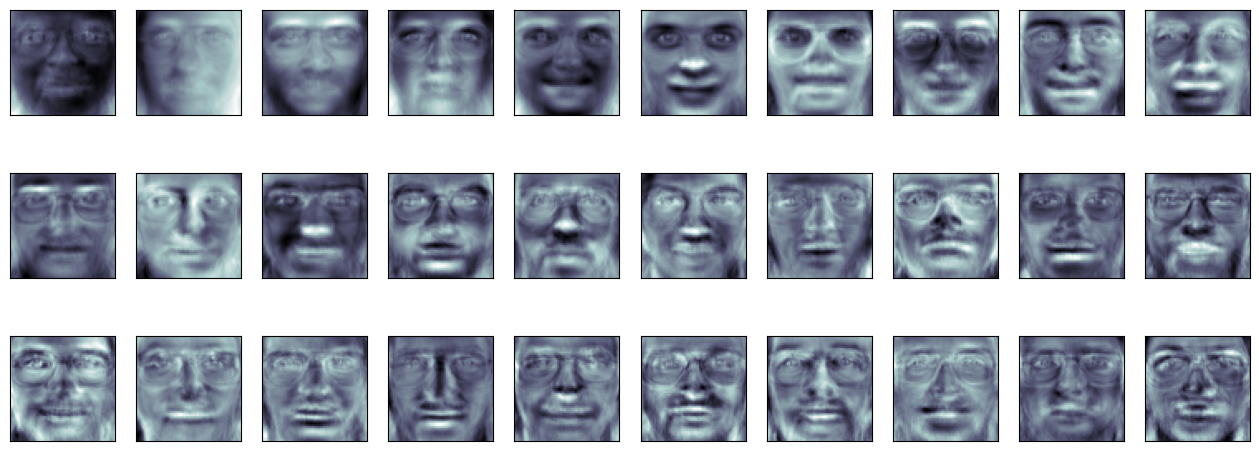

In [63]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:



In [64]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(320, 150)


In [65]:
print(X_test_pca.shape)

(80, 150)


>Devez-vous centrer les données avant d’appliquer l’ACP ?  

Oui, vous devez centrer les données avant d’appliquer l’Analyse en Composantes Principales (ACP). Le centrage est une étape essentielle car l'ACP cherche à identifier les axes principaux de la variance des données, et si les données ne sont pas centrées, le premier axe principal risque de correspondre simplement à la moyenne des données plutôt qu'aux variations autour de cette moyenne.

These projected components correspond to factors in a linear combination
of component images such that the combination approaches the original
face.

Doing the Learning: Support Vector Machines
-------------------------------------------

Now we'll perform support-vector-machine classification on this reduced
dataset:



### Pour chacun des trois classifieurs (SVM, régression logistique, KNN), veuillez chercher le nombre de composantes principales qui donne le meilleur score sur le jeu de test.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.925
n comp:19


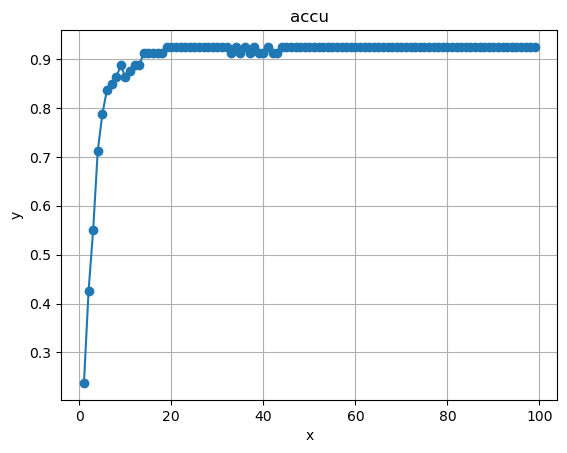

In [66]:
# Nous allons répeter ici les expériences de classification après l'ACP
# knn -- 112
# logreg
# svc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


i=1
best_c=0
best_a=0
hist=[]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

for k in range(1, 100):
    pca = decomposition.PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)
    
    acc = knn_clf(X_train_pca, y_train, X_test_pca, y_test)
    hist.append(acc)
    if acc > best_a:
        best_a = acc
        i=k
    print(k)
    
print(best_a)
print(f"n comp:{i}")
pl(1, 100, "accu", hist)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.9625
n comp:24


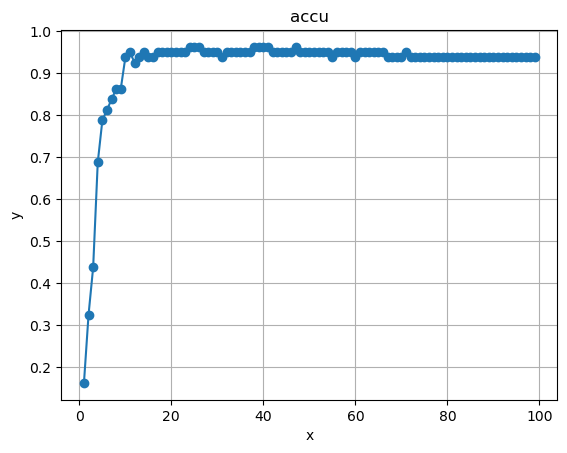

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


i=1
best_c=0
best_a=0
hist=[]



for k in range(1, 100):
    pca = decomposition.PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)
    
    acc = svc_clf(X_train_pca, y_train, X_test_pca, y_test)
    hist.append(acc)
    if acc > best_a:
        best_a = acc
        i=k
    print(k)
    
print(best_a)
print(f"n comp:{i}")
pl(1, 100, "accu", hist)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.975
n comp:42


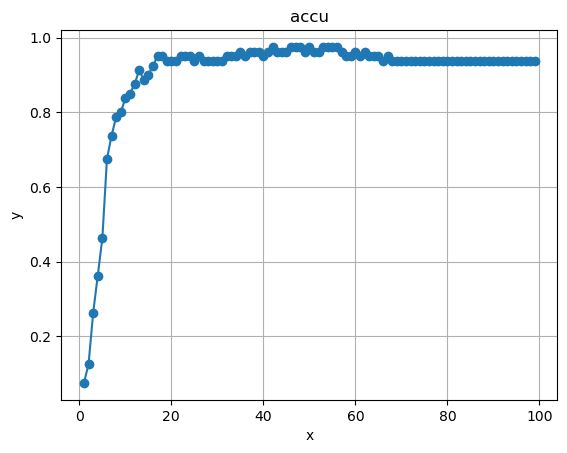

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


i=1
best_c=0
best_a=0
hist=[]



for k in range(1, 100):
    pca = decomposition.PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)
    
    acc = log_reg_clf(X_train_pca, y_train, X_test_pca, y_test)
    hist.append(acc)
    if acc > best_a:
        best_a = acc
        i=k
    print(k)
    
print(best_a)
print(f"n comp:{i}")
pl(1, 100, "accu", hist)

### 5. Refaites une expérience du point (3) avec les données transformées : quels sont les changements ?

In [69]:
pca = decomposition.PCA(n_components=24)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

acc_svc = svc_clf(X_train_pca, y_train, X_test_pca, y_test)

pca = decomposition.PCA(n_components=19)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

acc_knn = knn_clf(X_train_pca, y_train, X_test_pca, y_test)

pca = decomposition.PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

acc_log = log_reg_clf(X_train_pca, y_train, X_test_pca, y_test)

print(f"accuracy svc:{acc_svc}")
print(f"accuracy knn:{acc_knn}")
print(f"accuracy log reg:{acc_log}")

accuracy svc:0.9625
accuracy knn:0.925
accuracy log reg:0.875


On voit que le score obtenu avec SVM est de 0.9625, ce qui est meilleur que le score obtenu sans ACP. Cela signifie que l'ACP a permis de réduire le nombre de dimensions tout en conservant la plupart des informations utiles pour la classification. Par contre cet amélioration n'est pas très significative car le score obtenu sans ACP était déjà très bon et la différence n'est que de 1.25 %

### 7. Pour le meilleur système obtenu, affichez les 5 premières erreurs de classification, avec : (a) l’image mal classée, (b) une image de la personne supposée par le système, et (c) une image de la personne correcte. Veuillez commenter les similarités et différences.

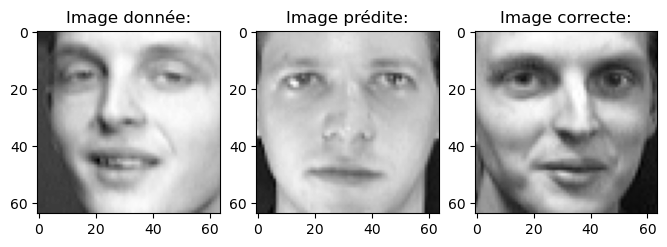

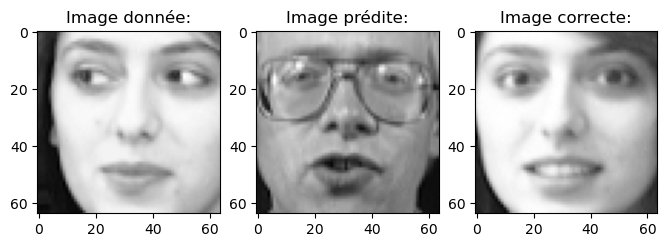

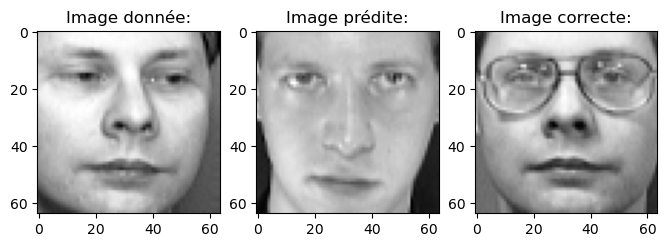

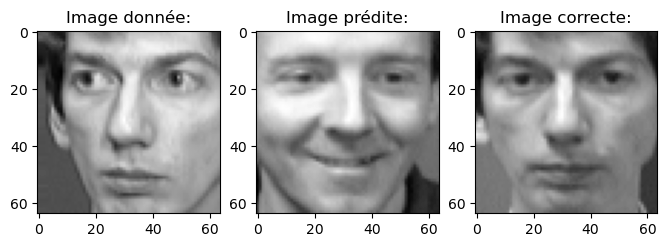

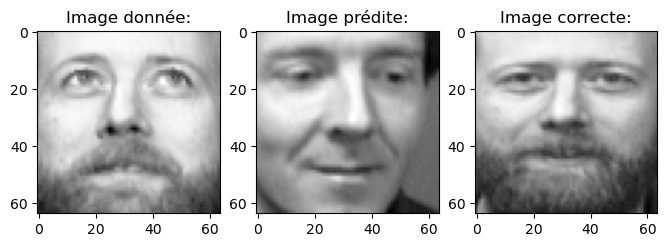

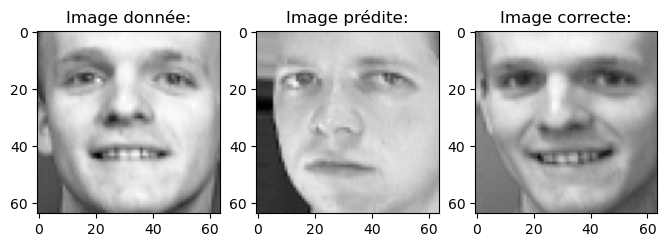

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# point 7 du labo
clf = svm.SVC(C=5., kernel='linear', gamma=0.001)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

incorrect_indices = (y_pred != y_test).nonzero()[0][:6]

for idx in incorrect_indices:
    
    # Image mal classée
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[idx].reshape(faces.images[0].shape), cmap='gray')
    plt.title('Image donnée:')
    
    # Image supposée par le système
    plt.subplot(1, 3, 2)
    plt.imshow(faces.images[y_pred[idx]], cmap='gray')
    plt.title('Image prédite:')

    correct_idx = np.where(y_test[idx] == faces.target)[0][0]

    # Image correcte
    plt.subplot(1, 3, 3)
    plt.imshow(faces.images[correct_idx], cmap='gray')
    plt.title('Image correcte:')

    plt.show()


Nous constatons que les erreurs de classification proviennent souvent d'images présentant des similitudes marquées ou partageant des caractéristiques distinctives, telles que le port de lunettes ou la présence d'une barbe. Ces attributs peuvent être communs à plusieurs individus, ce qui complique la tâche de classification pour le système. Néanmoins, malgré ces défis, le système a globalement bien performé, réussissant à classer correctement la majorité des images.

In [77]:
X_test[0].shape

(4096,)

In [72]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, gamma=0.001)

Finally, we can evaluate how well this classification did. First, we
might plot a few of the test-cases with the labels learned from the
training set:



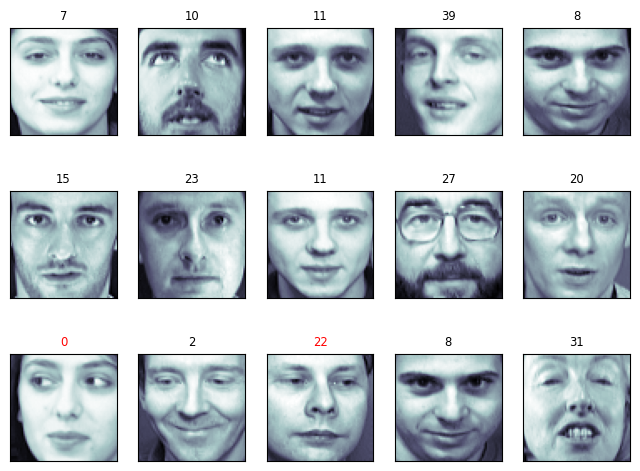

In [73]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

The classifier is correct on an impressive number of images given the
simplicity of its learning model! Using a linear classifier on 150
features derived from the pixel-level data, the algorithm correctly
identifies a large number of the people in the images.

Again, we can quantify this effectiveness using one of several measures
from :mod:`sklearn.metrics`. First we can do the classification
report, which shows the precision, recall and other measures of the
"goodness" of the classification:



In [74]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      0.50      0.67         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

c:\Users\crist\anaconda3\envs\pcd\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\crist\anaconda3\envs\pcd\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\crist\anaconda3\envs\pcd\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Another interesting metric is the *confusion matrix*, which indicates
how often any two items are mixed-up. The confusion matrix of a perfect
classifier would only have nonzero entries on the diagonal, with zeros
on the off-diagonal:



In [75]:
print(metrics.confusion_matrix(y_test, y_pred))

[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


Pipelining
----------

Above we used PCA as a pre-processing step before applying our support
vector machine classifier. Plugging the output of one estimator directly
into the input of a second estimator is a commonly used pattern; for
this reason scikit-learn provides a ``Pipeline`` object which automates
this process. The above problem can be re-expressed as a pipeline as
follows:



In [76]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('pca', decomposition.PCA(n_components=150, whiten=True)),
                ('svm', svm.LinearSVC(C=1.0))])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.confusion_matrix(y_pred, y_test))
plt.show()

c:\Users\crist\anaconda3\envs\pcd\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


c:\Users\crist\anaconda3\envs\pcd\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


A Note on Facial Recognition
----------------------------

Here we have used PCA "eigenfaces" as a pre-processing step for facial
recognition. The reason we chose this is because PCA is a
broadly-applicable technique, which can be useful for a wide array of
data types. Research in the field of facial recognition in particular,
however, has shown that other more specific feature extraction methods
are can be much more effective.



#### 8. Pour le meilleur système, veuillez tester en utilisant un test de Student apparié si l’utilisation de l’ACP est significativement supérieure (à un niveau de 5%) que l’absence d’ACP. Pour appliquer le test, veuillez utiliser la validation croisée, en construisant 5 « folds » 80%/20%.

In [78]:
from scipy import stats
rng = np.random.default_rng()

def compute_test_Student(a, b) :
    r = stats.ttest_rel(a, b)
    return r.pvalue

In [81]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Données
X= faces.data
Y = faces.target

def validation_croissee(scores_with_pca, scores_without_pca, n_components):

    # Préparer la validation croisée
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = list(kf.split(faces.data))

    for train_index, test_index in folds:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # Entraînement et évaluation avec ACP
        pca = PCA(n_components = n_components, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        model_with_pca = SVC(C=10.0, kernel='linear')
        model_with_pca.fit(X_train_pca, y_train)
        y_pred = model_with_pca.predict(X_test_pca)
        scores_with_pca.append(metrics.accuracy_score(y_test, y_pred))
        
        # Entraînement et évaluation sans ACP
        model_without_pca = SVC(C=10.0, kernel='linear')
        model_without_pca.fit(X_train, y_train)
        y_pred = model_without_pca.predict(X_test)
        scores_without_pca.append(metrics.accuracy_score(y_test, y_pred))

    return scores_with_pca, scores_without_pca

In [82]:
# Listes pour stocker les scores
scores_with_pca = []
scores_without_pca = []

# Exécuter la validation croisée avec n_components=24 pour l'ACP comme trouvé précédemment
scores_with_pca, scores_without_pca = validation_croissee(scores_with_pca, scores_without_pca, 24)

In [83]:
# Afficher les scores
print("Scores avec ACP:", scores_with_pca)
print("Scores sans ACP:", scores_without_pca)

Scores avec ACP: [0.9875, 0.9375, 0.9375, 0.9625, 0.9375]
Scores sans ACP: [0.975, 0.95, 0.95, 0.9625, 0.9375]


In [86]:
# Calculer la moyenne des scores
mean_score_with_pca = np.mean(scores_with_pca)
mean_score_without_pca = np.mean(scores_without_pca)

# Afficher les moyennes
print(f"Score moyen avec ACP: {mean_score_with_pca:.2f}")
print(f"Score moyen sans ACP: {mean_score_without_pca:.2f}")

Score moyen avec ACP: 0.95
Score moyen sans ACP: 0.96


In [84]:
compute_test_Student(scores_with_pca, scores_without_pca)

0.6213082950375013

Étant donné que la valeur p est de 0.6213, ce qui dépasse le seuil de 0.05, nous pouvons conclure que l'utilisation de l'Analyse en Composantes Principales (ACP) n'apporte pas d'amélioration significative par rapport à l'absence d'ACP. En d'autres termes, réduire les données à 24 composantes principales ne montre pas de bénéfice statistiquement significatif en termes de performance du modèle par rapport à ne pas utiliser l'ACP du tout.

## Conclusion :
Nous pouvons conclure que l'Analyse en Composantes Principales (ACP) a effectivement permis une réduction significative du nombre de dimensions tout en conservant une grande partie des informations pertinentes pour la classification. Toutefois, cette réduction n'a entraîné qu'une légère amélioration de la performance du modèle. Le meilleur résultat a été obtenu avec un classificateur SVM, atteignant un score impressionnant de 0.9875, avec l'application de l'ACP. Bien que les résultats soient globalement satisfaisants pour tous les classifieurs testés, le SVM sans ACP s'est avéré être le plus performant en moyenne. La comparaison des scores obtenus, avec et sans ACP, illustre clairement que l'ACP n'a pas surpassé l'approche sans réduction de dimensionnalité en termes de performance.